In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *

from annotation_utilities import *
from registration_utilities import *
from conversion import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Local Macbook Pro


In [24]:
stack = 'MD589'

In [25]:
filenames_to_sections = {f: s for s, f in metadata_cache['sections_to_filenames'][stack].iteritems() 
                         if not is_invalid(f)}

In [26]:
contour_df = DataManager.load_annotation_v4(stack=stack, by_human=True)
contour_df = convert_annotation_v3_original_to_aligned(contour_df, stack=stack)
# contour_df vertices wrt to aligned uncropped lossless image

In [27]:
# Treat section as a single z value or a whole voxel slice.

In [28]:
downscale = 32

In [29]:
def contours_2d_to_3d(matched_contours, convert_to='aligned'):
    """
    Convert matched annotation dataframe entries to contours as a list of 3d array.
    """
    
    contours_3d = []
    
    for cnt_id, cnt in matched_contours.iterrows():

        fn = cnt['filename']
        if is_invalid(fn=fn, stack=stack) or not isinstance(fn, str): # Sometimes fn is nan, don't know why.
            continue
        
        section = filenames_to_sections[fn]
        zl, zh = DataManager.convert_section_to_z(stack=stack, sec=section, downsample=downscale, z_begin=0, first_sec=1)
        z = int(np.round((zl + zh)/2))
        n = len(cnt['vertices'])
        vertices_on_aligned_3d = np.c_[cnt['vertices']/downscale, z*np.ones((n,))]
        contours_3d.append(vertices_on_aligned_3d)
        
    return contours_3d

In [31]:
contours_grouped_by_name = {}

for name_u in singular_structures:
#     print name_u
    
    matched_contours = contour_df[(contour_df['name'] == name_u)]
    if len(matched_contours) == 0:
        continue
    contours_3d = contours_2d_to_3d(matched_contours)
    contours_grouped_by_name[name_u] = contours_3d

for name_u in paired_structures:
#     print name_u

    matched_contours = contour_df[(contour_df['name'] == name_u) & (contour_df['side'] == 'L')]
    if len(matched_contours) == 0:
        continue
    contours_3d = contours_2d_to_3d(matched_contours)
    contours_grouped_by_name[convert_to_left_name(name_u)] = contours_3d
    
    matched_contours = contour_df[(contour_df['name'] == name_u) & (contour_df['side'] == 'R')]
    if len(matched_contours) == 0:
        continue
    contours_3d = contours_2d_to_3d(matched_contours)
    contours_grouped_by_name[convert_to_right_name(name_u)] = contours_3d

In [32]:
structure_to_label = {structure: i + 1 for i, structure in enumerate(sorted(contours_grouped_by_name.keys()))}
contours_grouped_by_label = {structure_to_label[name]: contours for name, contours in contours_grouped_by_name.iteritems()}

In [33]:
volume, bbox = contours_to_volume(contours_grouped_by_label=contours_grouped_by_label, 
                                  interpolation_direction='z', return_shell=False)
print bbox
# bbox with wrt aligned uncropped specimen space.

(622, 1042, 155, 502, 128, 503)


In [34]:
display_volume_sections(volume, every=2)

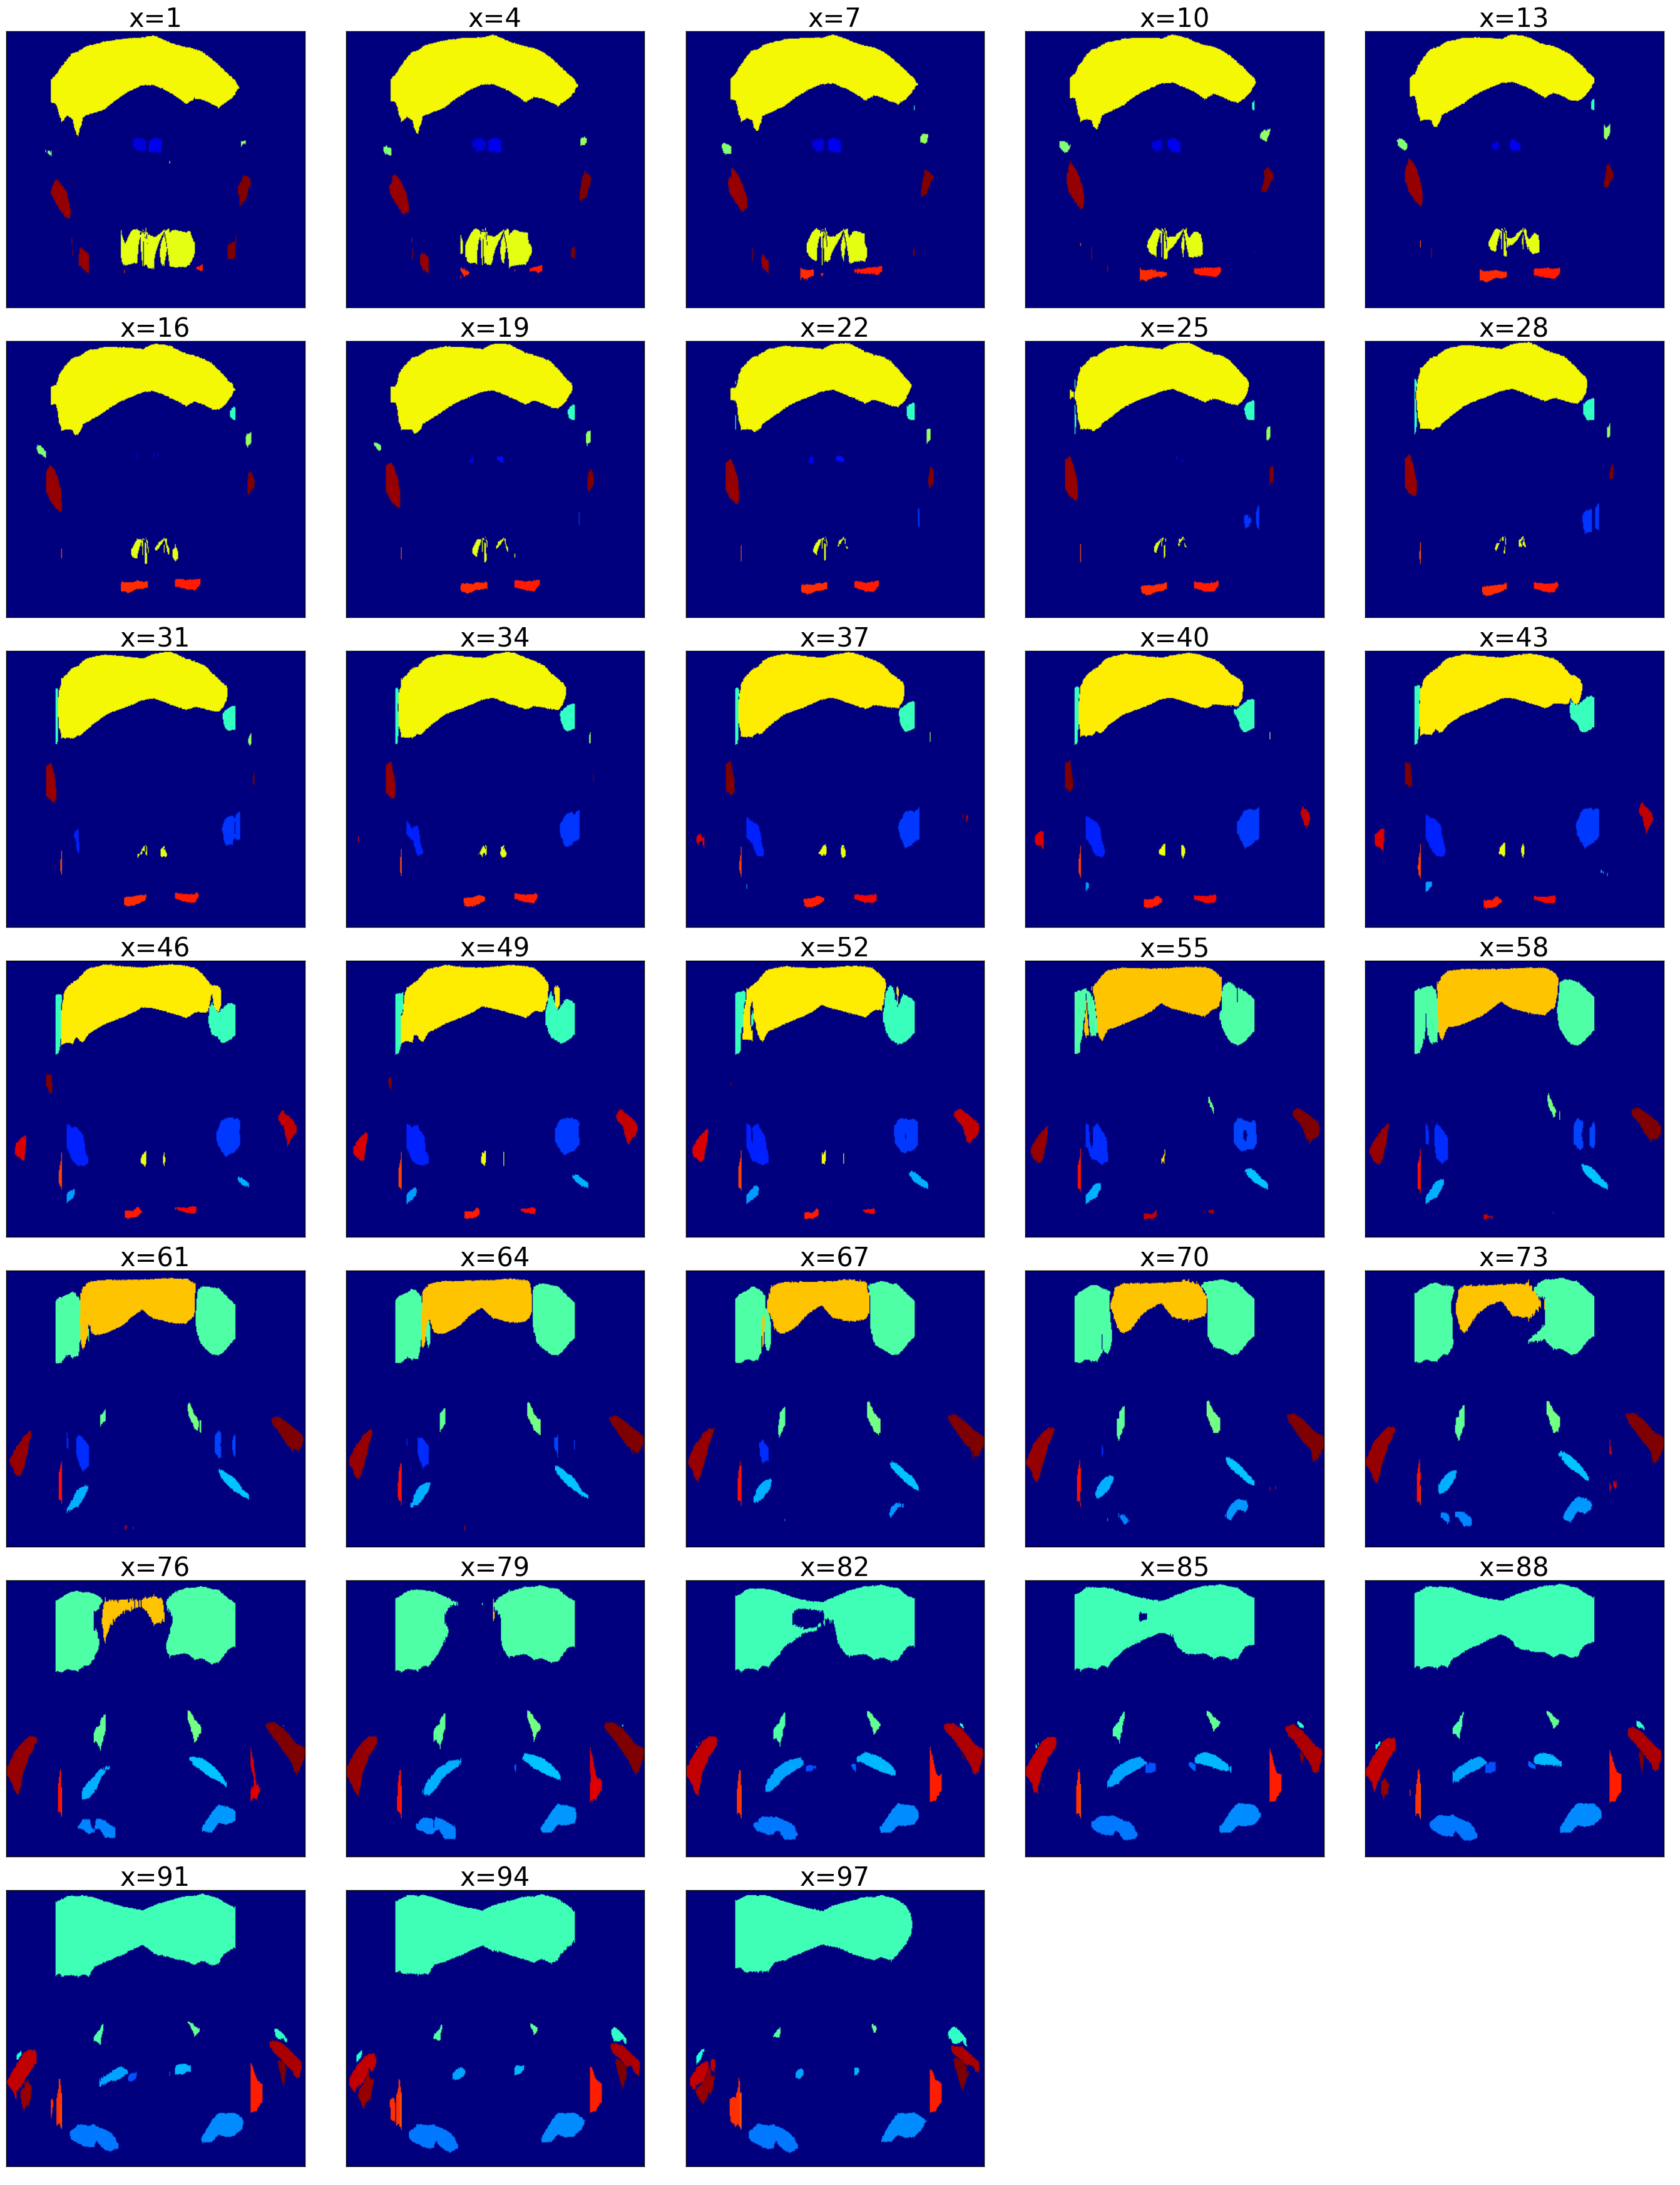

In [35]:
display_volume_sections(volume[:,100:200,:], every=3, direction='x')

# Output


In [36]:
vol_fp = DataManager.get_annotation_volume_filepath(stack=stack, downscale=downscale)
create_parent_dir_if_not_exists(vol_fp)
bp.pack_ndarray_file(volume, vol_fp)
upload_to_s3(vol_fp)

aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume.bp"


In [37]:
bbox_fp = DataManager.get_annotation_volume_bbox_filepath(stack=stack, downscale=downscale)
np.savetxt(bbox_fp, np.array(bbox)[None], fmt='%d')
upload_to_s3(bbox_fp)

aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume_bbox.txt"


In [38]:
name_label_map_fp = DataManager.get_volume_label_to_name_filepath(stack=stack)

with open(name_label_map_fp, 'w') as f:
    for structure, label in sorted(structure_to_label.items()):
        f.write(structure + ' ' + str(label) + '\n')
        
upload_to_s3(name_label_map_fp)

aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume_nameToLabel.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume_nameToLabel.txt"


In [34]:
# with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_down%(down)d_annotationVolume_landmarkBboxes.txt' % \
#                        dict(down=downsample_factor, stack=stack)), 'w') as f:
#     for name_s, label in sorted(name_s_to_label.items()):
#         bbox = bbox_3d(volume == label)
#         f.write(name_s + ' ' + ' '.join(map(str, bbox)) + '\n')

# Decompose as different volumes

In [39]:
volume = DataManager.load_annotation_volume(stack=stack, downscale=32)

print volume.shape

label_to_structure, structure_to_label = DataManager.load_volume_label_to_name(stack=stack)

# vol_xmin, vol_xmax, vol_ymin, vol_ymax, vol_zmin, vol_zmax = \
# DataManager.load_original_volume_bbox(stack=stack, volume_type='annotation', downscale=32)

volume_decomposed = annotation_volume_to_score_volume(volume, label_to_structure)

(348, 421, 376)


In [40]:
bbox = DataManager.load_original_volume_bbox(stack=stack, volume_type='annotation')

In [41]:
for structure, v in volume_decomposed.iteritems():
    fp = DataManager.get_original_volume_filepath(stack=stack, downscale=32, structure=structure, volume_type='annotationAsScore')
    create_parent_dir_if_not_exists(fp)
    bp.pack_ndarray_file(v, fp)
    upload_to_s3(fp)
    
    bbox_fp = DataManager.get_original_volume_bbox_filepath(stack=stack, downscale=32, structure=structure, volume_type='annotationAsScore')
    np.savetxt(bbox_fp, np.array(bbox)[None], fmt='%d')
    upload_to_s3(bbox_fp)

aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_LRt_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_LRt_R.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_LRt_R_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_LRt_R_bbox.txt"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_Sp5C_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_Sp5C_L.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVol